# Summary

Code based on https://arxiv.org/abs/1902.09833 
<br> Simulating a two level system emmiting a photon into a cavity using qutip.

---

In [31]:
!pip install qutip

In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:

#Defining the shape of the output pulse as a function of time
def v(t,args=None):
  return np.sqrt(gamma)*np.exp(-t*gamma/2)
  #return 0

#Defining |v(t)|^2 
def v_2(t):
  return np.conj(v(t))*v(t)

#Defining the time dependent coupling
def g(t, args):
  integral = quad(v_2, 0, t)[0]
  if integral == 0:
    return 0
  else:
    return -np.conj(v(t))/ ( integral**0.5 )


In [7]:
##    Defining All operators    ##

#Number of fock states in the output cavity
N = 2   

#Coupling constant         
gamma = 2

#Defining time of simulation
t = 500                                                                         #temporal resolution/ number of points taken
t_final = 20
times = np.linspace(0.0001, t_final, t)


#Defining initial state of the system and cavity, with the system in excited state 
psi0 = qutip.tensor(qutip.fock(2,1), qutip.fock(N, 0))

#Anihilation operator of the cavity
a  = qutip.tensor(qutip.qeye(2), qutip.destroy(N))

#Lowering operator of the system
c = qutip.tensor(qutip.destroy(2), qutip.qeye(N))

Hs = a.dag()*a                                                                  #system hamiltonian
H = [ [ 0.5j*(gamma**0.5)*( (c.dag()*a)-(a.dag()*c) ) , g]]                     #Net time dependent Hamiltonian (Eq 5 in the Quantum Pulses paper)

L_0 = [ (gamma**0.5)*c, [a, g] ]                                                #Lindblad operator 0 (Eq 6)

I = qutip.tensor(qutip.qeye(2), qutip.qeye(N))

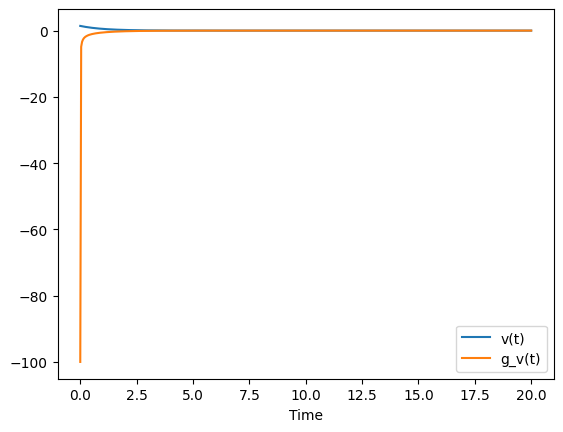

In [8]:
#Plotting out the output pulse and time dependent coupling
plt.plot(times, [v(t) for t in times]) 
plt.plot(times, [g(t, None) for t in times]) 
plt.xlabel('Time') 
plt.legend(("v(t)", "g_v(t)")) 

In [9]:
result = qutip.mesolve(H, psi0, times, [L_0,], [c.dag()*c, a.dag()*a])          #Evolving the system , with output c*c and a*a

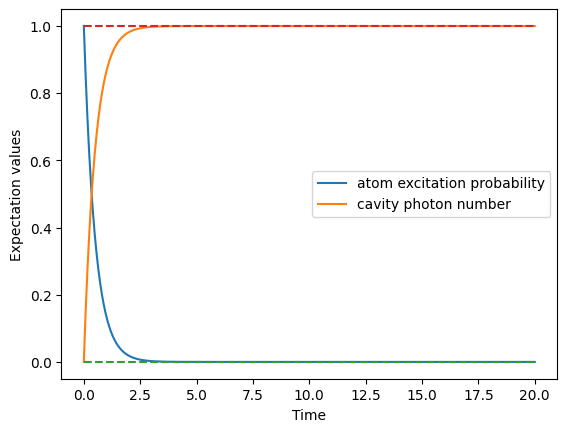

2

In [10]:
plt.figure() 
plt.plot(times, result.expect[0]) 
plt.plot(times, result.expect[1]) 
plt.xlabel('Time') 
plt.ylabel('Expectation values') 
plt.legend(("atom excitation probability", "cavity photon number")) 
plt.plot([times[0], times[-1]], [result.expect[0][-1], result.expect[0][-1]],'--')
plt.plot([times[0], times[-1]], [result.expect[1][-1], result.expect[1][-1]],'--')
plt.show() 
gamma

---
---
# Calculating probability lost ie <L_o*L_o>:

In [ ]:
I_0 = list()
result_states = qutip.mesolve(H, psi0, times, [L_0,], [])                      #Evolving the system , with output of rho's at various times
for q in range(t):
    L_0t = ( (gamma**0.5)*c + a*g(times[q], None) ) 
    I_0.append( (L_0t.dag() * L_0t * result_states.states[q]).tr() )

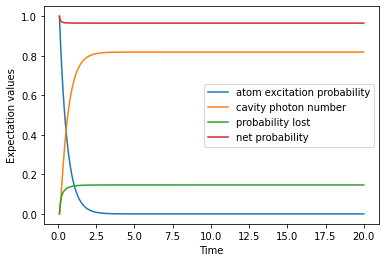

In [49]:
plt.figure() 
plt.plot(times, result.expect[0]) 
plt.plot(times, result.expect[1]) 
plt.plot(times, (np.cumsum(I_0)-I_0[0])*(times[1]-times[0]) )
plt.plot(times, (np.cumsum(I_0)-I_0[0])*(times[1]-times[0])+ result.expect[0]+result.expect[1])
plt.xlabel('Time') 
plt.ylabel('Expectation values') 
plt.legend(("atom excitation probability", "cavity photon number", "probability lost", "net probability")) 
#plt.plot([times[0], times[-1]], [result.expect[0][-1], result.expect[0][-1]],'--')
#plt.plot([times[0], times[-1]], [result.expect[1][-1], result.expect[1][-1]],'--')
plt.show() 

---
---
# Calculating ideal $v(t)$ using correlation funtion:

In [38]:
times = np.linspace(0, t_final, t)
#make syre to set v(t), ie all coupling to zero for this
correlation = qutip.correlation_2op_2t(H, psi0, times, times, [L_0,], (gamma**0.5)*c.dag(), (gamma**0.5)*c)

KeyboardInterrupt: 

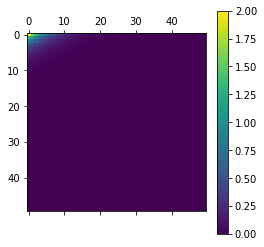

In [ ]:
plt.matshow(np.real(correlation))
plt.colorbar()
#plotting v(t) vs v(t+tau)

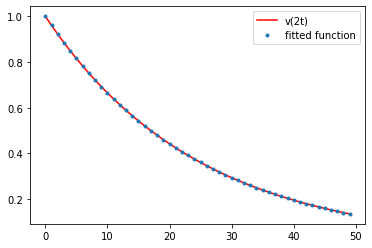

In [ ]:
plt.plot(np.real(correlation.T)[0]/np.real(correlation[0])[0], 'r')
plt.plot(range(t), [np.exp(-times[x]*gamma) for x in range(t)], '.')
plt.legend(("v(2t)", "fitted function")) 

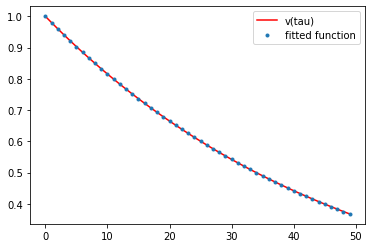

In [ ]:
plt.plot(np.real(correlation)[0]/np.real(correlation[0])[0], 'r')
plt.plot(range(t), [np.exp(-times[x]*gamma/2) for x in range(t)], '.')
plt.legend(("v(tau)", "fitted function")) 

--- 
---


# Archived testing code:

In [ ]:
g = 0.3
n = 100
times = np.linspace(0, 20, n)

#testing out the propogator 
rx, ry, rz = [2,1,-1]
norm = (rx**2 + ry**2 + rz**2 )**0.5 
rx = rx/norm
ry = ry/norm
rz = rz/norm

rho_0 = 0.5*(qutip.qeye(2) + (rz*qutip.sigmaz()) + (ry*qutip.sigmay()) + (rx*qutip.sigmax()))
#qutip.fock(2,1).full()

d = qutip.destroy(2)

#result = qutip.mesolve(qutip.qeye(2), rho_0, times, [(g**0.5)*d], [d,])         # H, rho(0), times, collapse op, obserbables

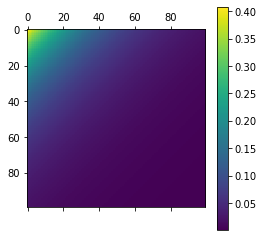

In [ ]:
cor = qutip.correlation_2op_2t(qutip.qeye(2), rho_0, times, times, [(g**0.5)*d,], d, qutip.qeye(2))
plt.matshow(np.real(cor))
plt.colorbar()

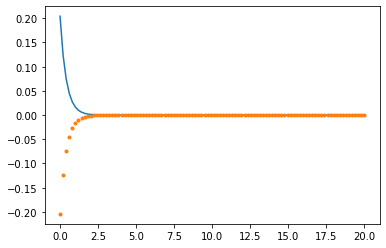

In [ ]:
plt.figure() 

plt.plot(times, result.expect[0]) 
plt.plot(times, [0.5*(1-rz)*np.exp(-x*gamma) for x in times], '.')
'''
plt.plot(times, np.imag(result.expect[0]) ) 
plt.plot(times, [0.5*(-ry)*np.exp(-x*gamma*0.5) for x in times], '.')
'''